In [7]:
%load_ext autoreload
%autoreload 2

import numpy as np
import os
import sys
import glob
import matplotlib.pyplot as plt
from tqdm import tqdm

sys.path.insert(0, '/project/vitelli/jonathan/REDO_fruitfly/src')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


Data shapes
Sqh:  (50, 236, 200, 2, 2)
Cad:  (50, 236, 200)
Vel:  (50, 236, 200, 2)
Coordinates shapes
XX:  (50, 236, 200) Range [3.22966, 455.701] um
YY:  (50, 236, 200) Range [3.22657, 536.891] um
TT:  (50, 236, 200) Range [-10, 39] min
(2360000, 1) (2360000, 1) (2360000, 1)
(2360000, 2, 2) (2360000, 1) (2360000, 2)
(100000, 1) (100000, 1) (100000, 1)
(100000, 2, 2) (100000, 1) (100000, 2)


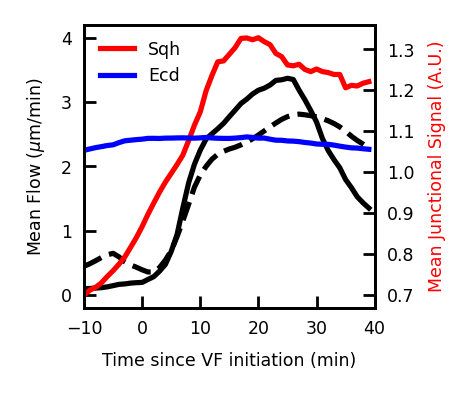

In [8]:
plt.rcParams['font.size'] = 5

loaddir = '../Public/WT/ECad-GFP/ensemble/'
cad = np.load(os.path.join(loaddir, 'raw2D.npy'), mmap_mode='r')
cad_vel = np.load(os.path.join(loaddir, 'velocity2D.npy'), mmap_mode='r')

loaddir = '../Public/Halo_Hetero_Twist[ey53]_Hetero/Sqh-GFP/ensemble/'
sqh = np.load(os.path.join(loaddir, 'tensor2D.npy'), mmap_mode='r')
vel = np.load(os.path.join(loaddir, 'velocity2D.npy'), mmap_mode='r')
t = np.load(os.path.join(loaddir, 't.npy'), mmap_mode='r')
y = np.load(os.path.join(loaddir, 'DV_coordinates.npy'), mmap_mode='r')
x = np.load(os.path.join(loaddir, 'AP_coordinates.npy'), mmap_mode='r')
              
    
sqh = sqh * 1e1
cad = cad
    
fig, ax = plt.subplots(1, 1, dpi=250, figsize=(1.5, 1.5))
ax2 = ax.twinx()
ax.plot(t, np.linalg.norm(vel, axis=1).mean(axis=(1, 2)), 
        color='black', label='Vel')
ax.plot(t, np.linalg.norm(cad_vel, axis=1).mean(axis=(1, 2)), 
        color='black', label='Vel', linestyle='--')
ax2.plot(t, np.linalg.norm(sqh, axis=(1, 2)).mean(axis=(1, 2)), 
         color='red', label='Sqh')
ax2.plot(t, cad.mean(axis=(1, 2)), 
         color='blue', label='Ecd')
ax2.legend(framealpha=0)

ax.set_ylim([-0.2, 4.2])
ax.set_xlim([-10, 40])
#ax2.set_yticks([80, 100, 120])
ax.set_yticks([0, 1, 2, 3, 4])

ax.set_ylabel('Mean Flow ($\\mu$m/min)')
ax2.set_ylabel('Mean Junctional Signal (A.U.)', color='red')
ax.set_xlabel('Time since VF initiation (min)')

print('Data shapes')

sqh = sqh.transpose(0, 3, 4, 1, 2)
cad = cad.transpose(0, 1, 2)

from scipy.ndimage import gaussian_filter
from atlas_processing.anisotropy_detection import cell_size
cad = gaussian_filter(cad, sigma=(0, 8, 8))
cad = 0.5 * (cad + cad[:, ::-1])

vel = vel.transpose(0, 2, 3, 1)

print('Sqh: ', sqh.shape)
print('Cad: ', cad.shape)
print('Vel: ', vel.shape)

nAP = x.shape[1]
nDV = y.shape[0]
nTP = t.shape[0]

XX = np.broadcast_to(x[None], (nTP, nDV, nAP))
YY = np.broadcast_to(y[None], (nTP, nDV, nAP))
TT = np.broadcast_to(t[:, None, None], (nTP, nDV, nAP))

print('Coordinates shapes')
print('XX: ', XX.shape, 'Range [%g, %g] um' % (XX.min(), XX.max()))
print('YY: ', YY.shape, 'Range [%g, %g] um' % (YY.min(), YY.max()))
print('TT: ', TT.shape, 'Range [%g, %g] min' % (TT.min(), TT.max()))

lower_bound = np.array([TT.min(), YY.min(), XX.min()])
upper_bound = np.array([TT.max(), YY.max(), XX.max()])

t = TT.flatten()[:, None]
y = YY.flatten()[:, None]
x = XX.flatten()[:, None]

sqh_train = sqh.reshape([-1, *sqh.shape[3:]])
cad_train = cad.reshape([-1, 1])
vel_train = vel.reshape([-1, *vel.shape[3:]])

print(t.shape, y.shape, x.shape)
print(sqh_train.shape, cad_train.shape, vel_train.shape)

N_train = 100000
idx = np.random.choice(nAP*nDV*nTP, N_train, replace=False)

x_train = x[idx, :]
y_train = y[idx, :]
t_train = t[idx, :]

sqh_train = sqh_train[idx, :]
cad_train = cad_train[idx, :]
vel_train = vel_train[idx, :]

print(t_train.shape, y_train.shape, x_train.shape)
print(sqh_train.shape, cad_train.shape, vel_train.shape)

MSE Loss: 5.164042e-03	Phys Loss: 1.083101e-02
	D_t m = 0.0149 (1 - 0.102 c) m + 0.15 (1 - -0.00146 c) m Tr(E) + 0.0885 (1 - -0.0168 c) m Tr(m) + -0.00708 (1 - 0.159 c) Gamma^DV Tr(m)
0.2727697981909873 0.06657624820448879 0.0


Text(0, 0.5, 'Cadherin')

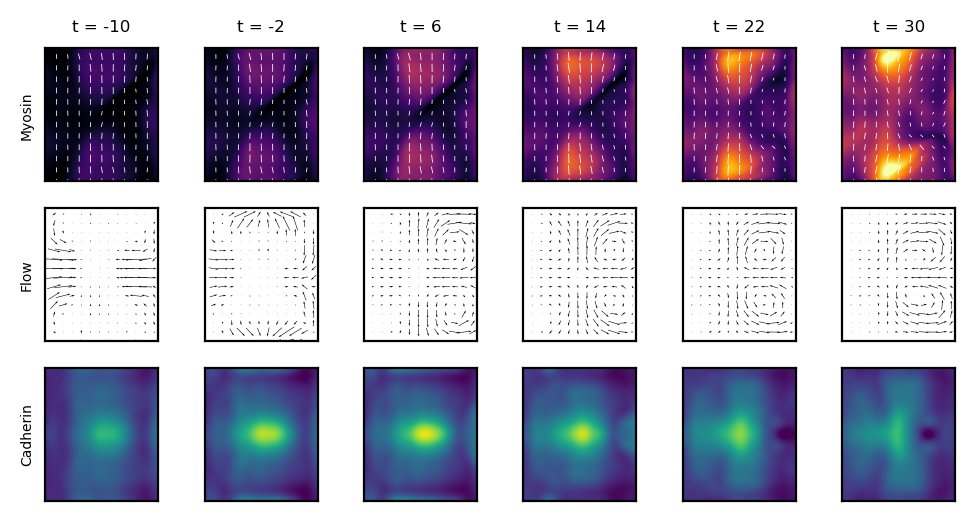

In [32]:
from utils.plot_utils import *
from run_MyosinDynamicsPINN import *
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = MyosinDynamicsPINN(
    t_train, y_train, x_train,
    sqh_train/1e1, cad_train, vel_train,
    lower_bound, upper_bound)
model.to(device)

dirs = './'
beta=1e-1
info = torch.load(os.path.join(dirs, f'{model.__class__.__name__}_beta={beta:.0e}.ckpt'), 
    map_location='cpu')
model.load_state_dict(info['state_dict'])
print(f"MSE Loss: {info['mse_loss']:e}\tPhys Loss: {info['phys_loss']:e}")

with torch.no_grad():
    model.print()
    m1, v1 = model(
        torch.from_numpy(t).float().to(device),
        torch.from_numpy(y).float().to(device),
        torch.from_numpy(x).float().to(device),
    )
    m1 = m1.cpu().numpy().reshape([nTP, nDV, nAP, 2, 2])
    v1 = v1.cpu().numpy().reshape([nTP, nDV, nAP, 2])
    c1 = cad
    print(np.mean((m1 - sqh)**2), np.mean((v1 - vel)**2), np.mean((c1 - cad)**2))
    
    m1 = m1.transpose(0, 3, 4, 1, 2)
    v1 = v1.transpose(0, 3, 1, 2)
    times = t.reshape([nTP, nDV, nAP])[..., 0, 0]
        
N = 6
fig, ax = plt.subplots(3, N, dpi=200, figsize=(N,3))
dt = min(10, sqh.shape[0] // N)
for i in range(N):
    ax[0, i].set_title('t = %d'% times[i*dt])
    plot_tensor2D(ax[0, i], m1[i*dt], vmin=0.06, vmax=0.25, cmap='inferno')
    plot_vector2D(ax[1, i], v1[i*dt], skip=16)
    color_2D(ax[2, i], c1[i*dt], cmap='viridis', vmin=0.8, vmax=1.8)
    
    for j in range(3):
        ax[j, i].set_ylim([dv_min, dv_max])
        
    
ax[0, 0].set_ylabel('Myosin')
ax[1, 0].set_ylabel('Flow')
ax[2, 0].set_ylabel('Cadherin')

MSE Loss: 4.897010e-03	Phys Loss: 9.928552e-03
	D_t m = 0.0139 (1 - 0.0586 c) m + -0.00398 (1 - 27.4 c) m Tr(E) + 0.0794 (1 - 8.94e-05 c) m Tr(m) + -0.00552 (1 - 0.215 c) Gamma^DV Tr(m)
0.27248361658127584 0.06918897820009423 0.0


Text(0, 0.5, 'Cadherin')

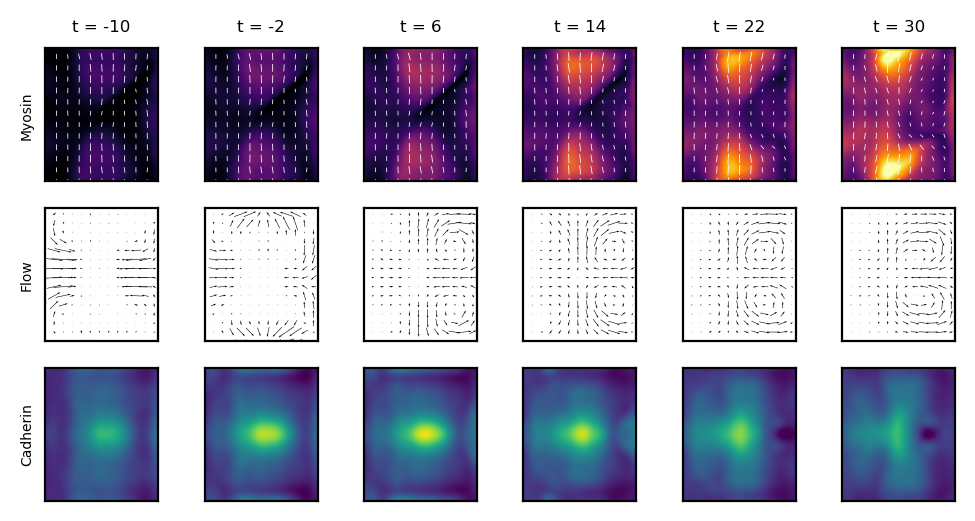

In [33]:
from utils.plot_utils import *
from run_MyosinDynamicsPINN import *
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = PositiveCoefficientsPINN(
    t_train, y_train, x_train,
    sqh_train/1e1, cad_train, vel_train,
    lower_bound, upper_bound)
model.to(device)

dirs = './version_6_9_2023/'
dirs = './'
beta=1e-1
info = torch.load(os.path.join(dirs, f'{model.__class__.__name__}_beta={beta:.0e}.ckpt'), 
    map_location='cpu')
model.load_state_dict(info['state_dict'])
print(f"MSE Loss: {info['mse_loss']:e}\tPhys Loss: {info['phys_loss']:e}")

with torch.no_grad():
    model.print()
    m1, v1 = model(
        torch.from_numpy(t).float().to(device),
        torch.from_numpy(y).float().to(device),
        torch.from_numpy(x).float().to(device),
    )
    m1 = m1.cpu().numpy().reshape([nTP, nDV, nAP, 2, 2])
    v1 = v1.cpu().numpy().reshape([nTP, nDV, nAP, 2])
    c1 = cad
    print(np.mean((m1 - sqh)**2), np.mean((v1 - vel)**2), np.mean((c1 - cad)**2))
    
    m1 = m1.transpose(0, 3, 4, 1, 2)
    v1 = v1.transpose(0, 3, 1, 2)
    times = t.reshape([nTP, nDV, nAP])[..., 0, 0]
        
N = 6
fig, ax = plt.subplots(3, N, dpi=200, figsize=(N,3))
dt = min(10, sqh.shape[0] // N)
for i in range(N):
    ax[0, i].set_title('t = %d'% times[i*dt])
    plot_tensor2D(ax[0, i], m1[i*dt], vmin=0.06, vmax=0.25, cmap='inferno')
    plot_vector2D(ax[1, i], v1[i*dt], skip=16)
    color_2D(ax[2, i], c1[i*dt], cmap='viridis', vmin=0.8, vmax=1.8)
    
    for j in range(3):
        ax[j, i].set_ylim([dv_min, dv_max])
        
    
ax[0, 0].set_ylabel('Myosin')
ax[1, 0].set_ylabel('Flow')
ax[2, 0].set_ylabel('Cadherin')

Allowed cadherin range:  0.7268965321278927 1.788796190122981
MSE Loss: 3.502348e-04	Phys Loss: 4.374179e-04
	D_t m = 0.0293 (1 - 0.522 c) m + 0.642 (1 - 1 c) m Tr(E) + -0.0311 (1 - 0.00673 c) m Tr(m) + 0.0106 (1 - 0.998 c) Gamma^DV Tr(m)
0.2729083595862629 0.09463858886854494 0.1423072389616453


Text(0, 0.5, 'Cadherin')

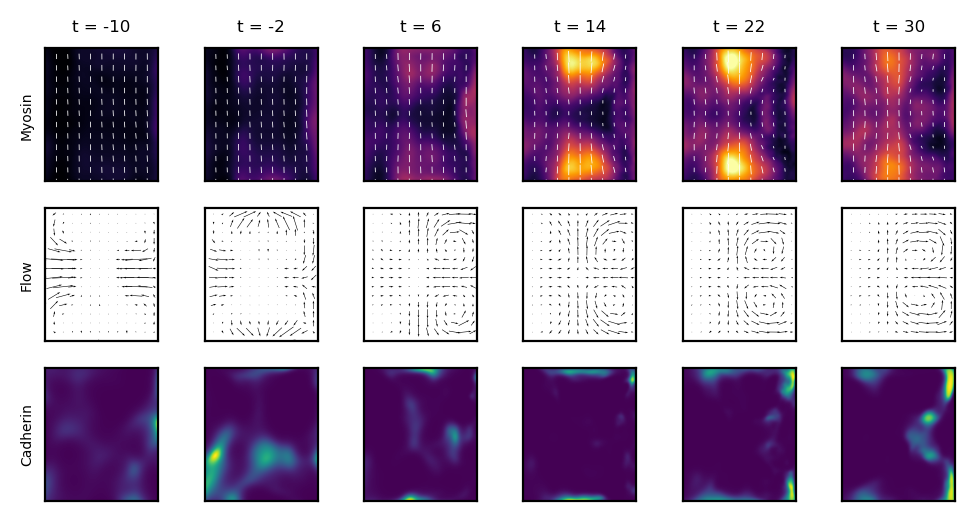

In [35]:
from utils.plot_utils import *
from run_MyosinDynamicsPINN import *
import torch

device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
model = DorsalSourcePINN(
    t_train, y_train, x_train,
    sqh_train/1e1, cad_train, vel_train,
    lower_bound, upper_bound)
model.to(device)

dirs = './version_6_9_2023/'
dirs = './'
beta=1e-1
info = torch.load(os.path.join(dirs, f'{model.__class__.__name__}_beta={beta:.0e}.ckpt'), 
    map_location='cpu')
model.load_state_dict(info['state_dict'])
print(f"MSE Loss: {info['mse_loss']:e}\tPhys Loss: {info['phys_loss']:e}")

with torch.no_grad():
    model.print()
    m1, v1, c1 = model(
        torch.from_numpy(t).float().to(device),
        torch.from_numpy(y).float().to(device),
        torch.from_numpy(x).float().to(device),
    )
    m1 = m1.cpu().numpy().reshape([nTP, nDV, nAP, 2, 2])
    v1 = v1.cpu().numpy().reshape([nTP, nDV, nAP, 2])
    c1 = c1.cpu().numpy().reshape([nTP, nDV, nAP])
    print(np.mean((m1 - sqh)**2), np.mean((v1 - vel)**2), np.mean((c1 - cad)**2))
    
    m1 = m1.transpose(0, 3, 4, 1, 2)
    v1 = v1.transpose(0, 3, 1, 2)
    times = t.reshape([nTP, nDV, nAP])[..., 0, 0]
        
N = 6
fig, ax = plt.subplots(3, N, dpi=200, figsize=(N,3))
dt = min(10, sqh.shape[0] // N)
for i in range(N):
    ax[0, i].set_title('t = %d'% times[i*dt])
    plot_tensor2D(ax[0, i], m1[i*dt], vmin=0.06, vmax=0.25, cmap='inferno')
    plot_vector2D(ax[1, i], v1[i*dt], skip=16)
    color_2D(ax[2, i], c1[i*dt], cmap='viridis')#, vmin=model.cad_min, vmax=model.cad_max)
    
    for j in range(3):
        ax[j, i].set_ylim([dv_min, dv_max])
        
    
ax[0, 0].set_ylabel('Myosin')
ax[1, 0].set_ylabel('Flow')
ax[2, 0].set_ylabel('Cadherin')

Text(0, 0.5, 'Cadherin')

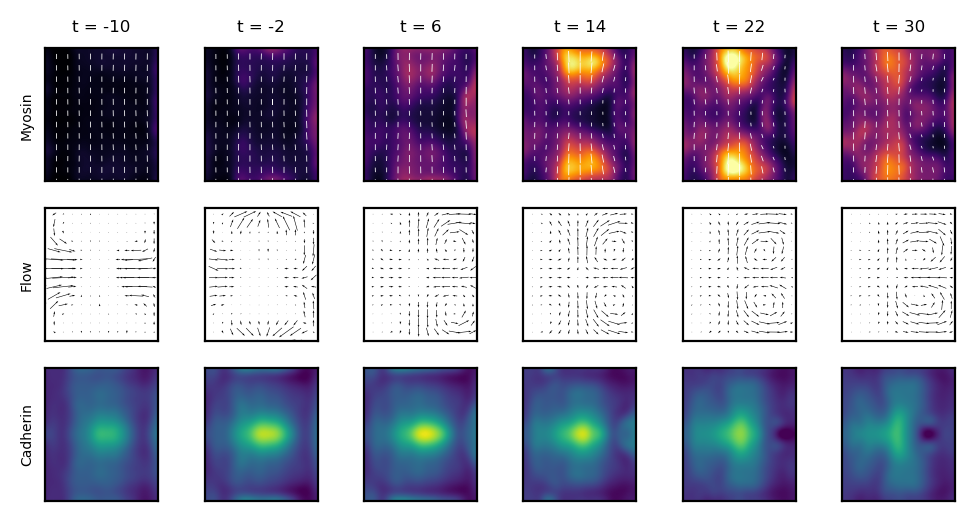

In [26]:
fig, ax = plt.subplots(3, N, dpi=200, figsize=(N,3))
dt = min(10, sqh.shape[0] // N)
for i in range(N):
    ax[0, i].set_title('t = %d'% times[i*dt])
    plot_tensor2D(ax[0, i], sqh[i*dt].transpose(2, 3, 0, 1).reshape([4, 236, 200]) / 1e1, 
                  vmin=0.06, vmax=0.25, cmap='inferno')
    plot_vector2D(ax[1, i], vel[i*dt].transpose(2, 0, 1), skip=16)
    color_2D(ax[2, i], cad[i*dt], cmap='viridis', vmin=0.8, vmax=1.8)
    
    for j in range(3):
        ax[j, i].set_ylim([dv_min, dv_max])
        
    
ax[0, 0].set_ylabel('Myosin')
ax[1, 0].set_ylabel('Flow')
ax[2, 0].set_ylabel('Cadherin')

In [29]:
model.model

Sequential(
  (0): Linear(in_features=3, out_features=128, bias=True)
  (1): Sin()
  (2): Linear(in_features=128, out_features=128, bias=True)
  (3): Sin()
  (4): Linear(in_features=128, out_features=128, bias=True)
  (5): Sin()
  (6): Linear(in_features=128, out_features=128, bias=True)
  (7): Sin()
  (8): Linear(in_features=128, out_features=128, bias=True)
  (9): Sin()
  (10): Linear(in_features=128, out_features=128, bias=True)
  (11): Sin()
  (12): Linear(in_features=128, out_features=128, bias=True)
  (13): Sin()
  (14): Linear(in_features=128, out_features=6, bias=True)
)